In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae
import time
import utils.entropy_funcs as ef 

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "test_run"
# params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["file_location"] = "/media/tbell/datasets/test_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 49000
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

#entropy params
params["LAMBDA"] = 0.1
params["num_triangles"] = 20
params["mle_lr"] = 0.2
params["num_mle_steps"] = 50
params["quant_noise_scale"] = 1.0/128.0 # simulating quantizing u in {-1.0, 1.0} to uint8 (256 values)
mle_triangle_centers = np.linspace(params["mem_v_min"], params["mem_v_max"], params["num_triangles"])

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  mem_std_eps = np.random.standard_normal((cae_model.params["effective_batch_size"], cae_model.params["n_mem"])).astype(np.float32)
  feed_dict={cae_model.memristor_std_eps:mem_std_eps, cae_model.triangle_centers:mle_triangle_centers}
  if not params["memristorify"] and not params["gauss_chan"]:
    quant_noise = np.random.uniform(-params["quant_noise_scale"], params["quant_noise_scale"],
      size=(cae_model.params["effective_batch_size"], cae_model.params["n_mem"]))
    feed_dict[cae_model.quantization_noise] = quant_noise

  t0 = time.time()
  # Update MLE estimate
  #sess.run(cae_model.reset_mle_thetas, feed_dict)
  old_thetas = sess.run(cae_model.mle_thetas, feed_dict)
  for mle_step in range(params["num_mle_steps"]):
    _, thetas, grads = sess.run([cae_model.mle_update, cae_model.mle_thetas, cae_model.mle_grads], feed_dict)
    print("\n", mle_step, " - grads: ", grads.shape, "\t", np.mean(grads[0,:]), "\t", np.var(grads[0,:]))
    print(mle_step, " - weight diffs: ", np.mean(np.square(old_thetas[0,:]-thetas[0,:])), "\t", np.var(old_thetas[0,:]-thetas[0,:]))
    old_thetas = thetas
  
  #_, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  latent_ent_list, u_list = sess.run([cae_model.latent_entropies, cae_model.u_list], feed_dict)

  #tri_linspace = tf.stack([tf.linspace(tf.reduce_min(cae_model.u_list[int(params["num_layers"]/2)]),
  #  tf.reduce_max(cae_model.u_list[int(params["num_layers"]/2)]), num=1000),]*params["n_mem"], axis=1)
  #tri_evals, tri_lin_eval = sess.run([ef.eval_triangle(tri_linspace, ef.weights(cae_model.mle_thetas), cae_model.triangle_centers),
  #  tri_linspace], feed_dict)
  u_vals = tf.reshape(u_list[int(params["num_layers"]/2)], (params["effective_batch_size"], params["n_mem"]))
  u_tri_evals = sess.run(ef.eval_triangle(u_vals, ef.weights(cae_model.mle_thetas), cae_model.triangle_centers), feed_dict)
  tri_heights, tri_centers = sess.run([ef.weights(cae_model.mle_thetas), cae_model.triangle_centers], feed_dict)

  t1 = time.time()
  t_tot = t1-t0
  print("total_time: ",t_tot)
  
  coord.request_stop()
  coord.join(enqueue_threads)


grads:  (32768, 20) 	 1.07739 	 0.10615
weight diffs:  0.0 	 0.0

grads:  (32768, 20) 	 0.632633 	 0.255911
weight diffs:  0.0506769 	 0.004246

grads:  (32768, 20) 	 0.283465 	 0.418207
weight diffs:  0.0262454 	 0.0102364

grads:  (32768, 20) 	 0.00890151 	 0.00136356
weight diffs:  0.0199424 	 0.0167283

grads:  (32768, 20) 	 0.00616238 	 0.000675514
weight diffs:  5.77117e-05 	 5.45422e-05

grads:  (32768, 20) 	 0.00481146 	 0.00041895
weight diffs:  2.85396e-05 	 2.70206e-05

grads:  (32768, 20) 	 0.00407791 	 0.000304143
weight diffs:  1.76839e-05 	 1.67579e-05

grads:  (32768, 20) 	 0.00332909 	 0.0002042
weight diffs:  1.2831e-05 	 1.21658e-05

grads:  (32768, 20) 	 0.00294808 	 0.000160941
weight diffs:  8.61144e-06 	 8.16811e-06

grads:  (32768, 20) 	 0.00214027 	 8.51536e-05
weight diffs:  6.7852e-06 	 6.43756e-06

grads:  (32768, 20) 	 0.00208955 	 8.13633e-05
weight diffs:  3.58946e-06 	 3.40622e-06

grads:  (32768, 20) 	 0.0019967 	 7.44524e-05
weight diffs:  3.4292e-06 

In [4]:
def calc_hist(u_val, num_bins):
    value_range = (np.min(u_val), np.max(u_val))
    hist, bin_edges = np.histogram(u_val, range=value_range, bins=num_bins)
    hist = hist/np.sum(hist)
    return bin_edges, hist

In [5]:
def plot_hists(latent_vals, u_val, num_plots, tri_x, tri_eval, tri_centers, tri_heights):
    fig, ax = plt.subplots(num_plots, 3, figsize=(20, 5*num_plots))
    for plot in range(num_plots):
        entropy = latent_vals[plot]
        bin_edges, hist = calc_hist(u_val[plot], 20)
        print ("gauss_ent", plot, " ", 0.5*np.log(2*np.pi*np.e*np.var(u_val[plot])))
        print("u_var", plot, " ", np.var(u_val[plot]))
        ax[plot, 0].scatter(bin_edges[:-1], hist)
        for index in np.arange(len(hist[:-1])):
          x_points = [bin_edges[index], bin_edges[index+1]]
          y_points = [hist[index], hist[index+1]]
          ax[plot, 0].plot(x_points, y_points, linewidth=2, color="k")
        ax[plot, 0].set_title("Entropy="+str(round(entropy,4)), fontsize=18)
        ylim = ax[plot, 0].get_ylim()
        ax[plot, 0].set_ylim((0, ylim[1]))
        ax[plot, 1].bar(tri_x[plot], np.sum(tri_eval[plot], axis=1), width=0.01)
        ax[plot, 2].bar(tri_centers, tri_heights[plot], width=0.01)
    plt.show()

gauss_ent 0   1.78670120916
u_var 0   2.08658
gauss_ent 1   1.93841202093
u_var 1   2.82624
gauss_ent 2   1.81486523749
u_var 2   2.20748
gauss_ent 3   2.4200270249
u_var 3   7.40516
gauss_ent 4   1.88846191706
u_var 4   2.55754


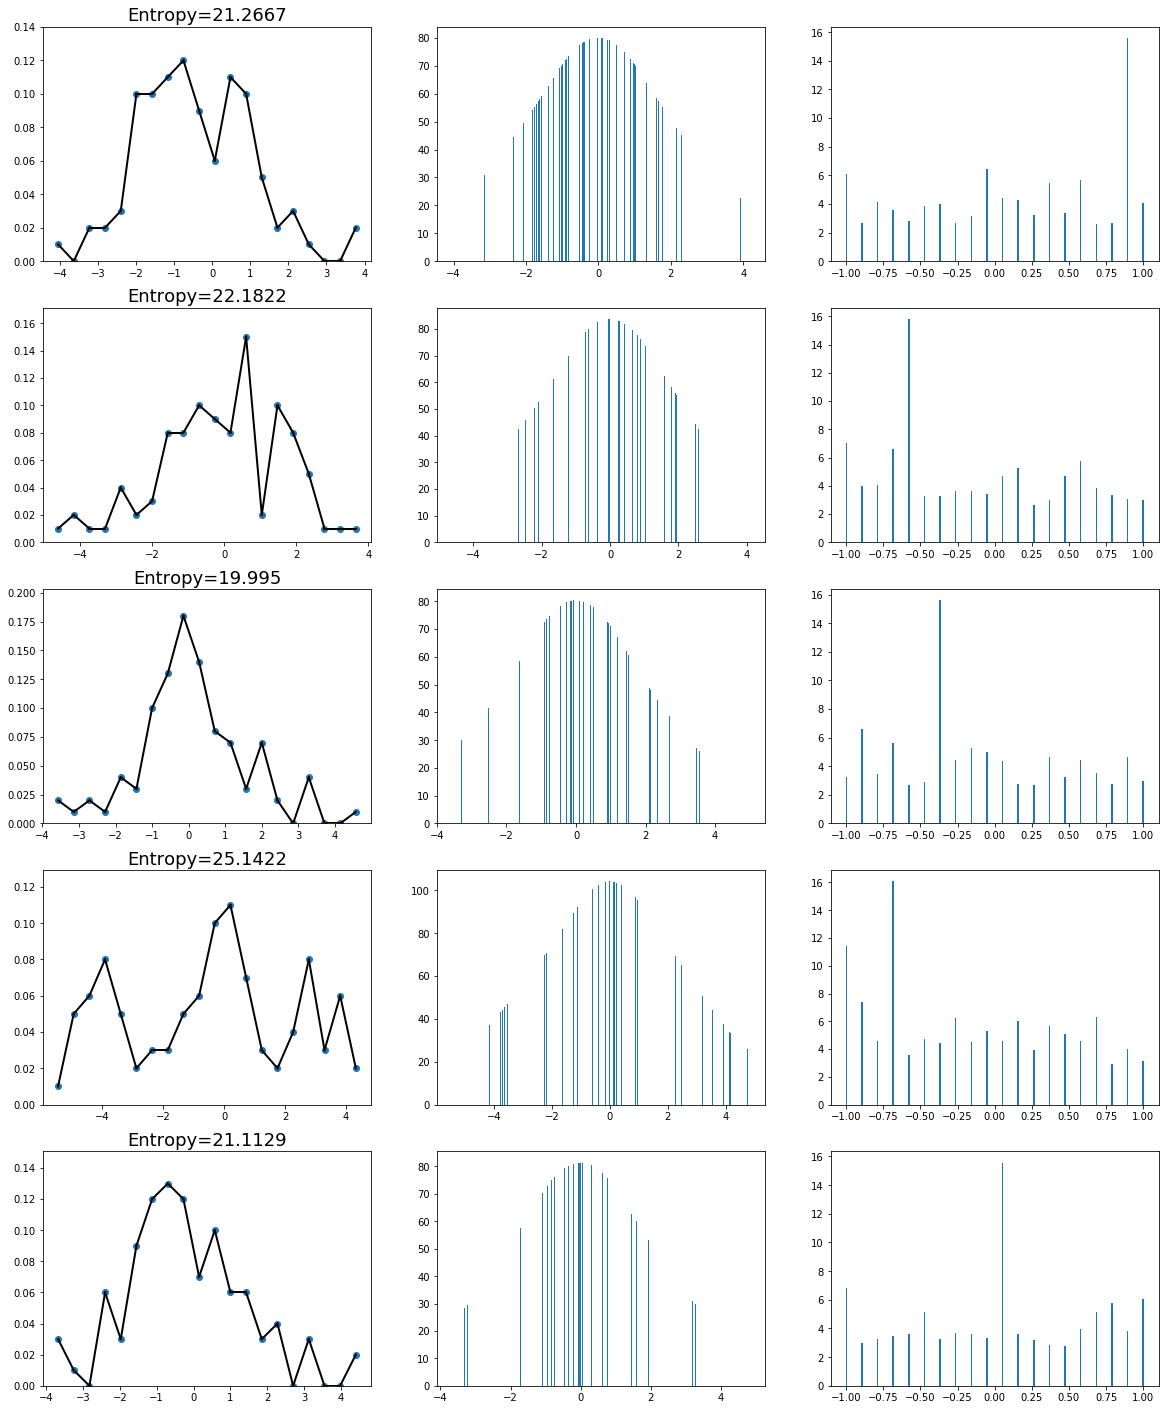

In [7]:
num_plots = 5
rand_val_index = np.random.choice(len(latent_ent_list), num_plots, replace=False)
latent_vals = [latent_ent_list[idx] for idx in rand_val_index]
u_vals = np.reshape(u_list[int(params["num_layers"]/2)], newshape=(params["batch_size"], params["n_mem"]))
u_val = [u_vals[:,idx] for idx in rand_val_index]
tri_eval = [u_tri_evals[:, idx, :] for idx in rand_val_index]
tri_x = u_val
#tri_eval = [tri_evals[:, idx, :] for idx in rand_val_index]
#tri_x = [tri_lin_eval[:, idx] for idx in rand_val_index]
tri_height = [tri_heights[idx,:] for idx in rand_val_index]
plot_hists(latent_vals, u_val, num_plots, tri_x, tri_eval, tri_centers, tri_height)